# Flexible fairness for batch correction
## Latent combination tutorial for erythroid organ inference

### The model that will be loaded in the following cells, has been trained on the Suo et al. dataset using the following script:
https://github.com/stathismegas/CellDISECT_reproducibility/blob/main/reproduce_benchmarks/suo/suo_train_noAge.py

In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import gc
torch.set_float32_matmul_precision('medium')
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import warnings
from tqdm import tqdm
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore")

from celldisect import CellDISECT

Global seed set to 0
Global seed set to 0


In [2]:
data_path = '/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility/figure_notebooks/antony/suo_prep_data.h5ad'

adata = sc.read_h5ad(data_path)
adata.X = adata.layers['counts'].copy()
adata = adata[adata.X.sum(1) != 0].copy()
adata.var['highly_variable'] = adata.var['highly_variable'].astype(bool)

cats = ['integration_donor', 'integration_library_platform_coarse',
        'organ']
cell_type_included = False # Set to True if you have provided a cell type annotation in the cats list

if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
adata

AnnData object with n_obs × n_vars = 841966 × 8192
    obs: 'study', 'sample_ID', 'lane_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'sample_status', 'library_platform', 'strand_sequence', 'biological_unit', 'doi', 'institute', 'study_PI', 'subject_ID', 'ethnicity_1', 'ethnicity_2', 'disease_known', 'disease_condition', 'subject_type', 'sample_type', 'sample_cultured', 'anatomical_region', 'anatomical_region_level_2', 'protocol_tissue_dissociation', 'cell_enrichment', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sequencing_platform', 'Sample_orig_author', 'Anatomical_region_orig_author', 'Termination_method_orig_author', 'Method_orig_author', 'anno_lvl_2_final_clean_orig_author', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'author_batch', 'Chuan_meta_Original_Label', 'Chuan_meta_Harmonised_Label', 'Chuan_meta_Tissue', 'Chuan_meta_Technology', 'Chuan_meta_Donor', 'Chua

In [3]:
pd.set_option('display.max_rows', 500)

adata.obs['orig_anno'].value_counts()

orig_anno
MID_ERY                                  55104
MACROPHAGE_IRON_RECYCLING                48640
MACROPHAGE_LYVE1_HIGH                    35001
NK                                       30284
FIBROBLAST_VII                           30142
FIBROBLAST_I                             25041
DP(P)_T                                  22839
FIBROBLAST_IV                            22634
YS_ERY                                   20370
MATURE_B                                 17489
MACROPHAGE_MHCII_HIGH                    14872
MACROPHAGE_PROLIFERATING                 14391
DN(Q)_T                                  13655
CD4+T                                    13649
FIBROBLAST_VIII                          12719
ENDOTHELIUM_IV                           12601
DP(Q)_T                                  12390
EARLY_ERY                                11897
MONOCYTE_I_CXCR4                         11891
DC2                                      11491
FIBROBLAST_X                             11415
MYO

In [4]:
celltypes = [
'MID_ERY',
'EARLY_ERY',
'LATE_ERY',
'HSC_MPP',
'MEMP',
'CYCLING_MEMP',
'MEP',
]

In [5]:
adata = adata[adata.obs['orig_anno'].isin(celltypes)].copy()

In [6]:
module_name = f'Antony_suoFull_NoAge'
pre_path = f'/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models/{module_name}'
model_name = 'development_clustering_pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.02_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_new_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_weighted_classifier_False'

model = CellDISECT.load(f"{pre_path}/{model_name}", adata=adata)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models/Antony_suoFull_NoAge/development_clustering_pre
         trainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.02_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e
         -05_new_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_weighted_classifier_False/model.pt already
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


In [7]:
adata

AnnData object with n_obs × n_vars = 90520 × 8192
    obs: 'study', 'sample_ID', 'lane_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'sample_status', 'library_platform', 'strand_sequence', 'biological_unit', 'doi', 'institute', 'study_PI', 'subject_ID', 'ethnicity_1', 'ethnicity_2', 'disease_known', 'disease_condition', 'subject_type', 'sample_type', 'sample_cultured', 'anatomical_region', 'anatomical_region_level_2', 'protocol_tissue_dissociation', 'cell_enrichment', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sequencing_platform', 'Sample_orig_author', 'Anatomical_region_orig_author', 'Termination_method_orig_author', 'Method_orig_author', 'anno_lvl_2_final_clean_orig_author', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'author_batch', 'Chuan_meta_Original_Label', 'Chuan_meta_Harmonised_Label', 'Chuan_meta_Tissue', 'Chuan_meta_Technology', 'Chuan_meta_Donor', 'Chuan

## You can get the latents related to each of the covariates separately

In [8]:
# Get the latent representations
print(f"Getting the latent 0...")
# Z_0
adata.obsm[f"CellDISECT_Z_0"] = model.get_latent_representation(
    nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False
)

for i in range(len(cats)):
    print(f"Getting the latent {i+1} / {len(cats)}...")
    null_idx = [s for s in range(len(cats)) if s != i]
    label = cats[i]
    # Z_i
    adata.obsm[f"CellDISECT_Z_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=null_idx, nullify_shared=True
    )
    # Z_{-i}
    adata.obsm[f"CellDISECT_Z_not_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=[i], nullify_shared=False
    )

Getting the latent 0...
Getting the latent 1 / 3...
Getting the latent 2 / 3...
Getting the latent 3 / 3...


## You can also use the combination of covariates/latents as you like, here we are using a combination/concatenation of Z0 with each of the covariates to make new latents Z0+ZCov

In [9]:
# Z_{0+Z_i} = Z_0 + Z_i | Optional
# This represents the combination of latents with Z_0.
# Here, Z_i is a vector where all elements are zero except for the i-th section.
# Z_0 is [latent_0, 0, ..., 0] and Z_i is [0, ..., 0, latent_i, 0, ..., 0].
# When mixing two latents, it will look like [latent_0, 0, latent_i, 0, ..., 0].
for i in range(len(cats)):  # loop over all Z_i
    label = cats[i]
    latent_name = f"CellDISECT_Z_0+{label}"
    adata.obsm[latent_name] = (
        adata.obsm["CellDISECT_Z_0"].copy() + adata.obsm[f"CellDISECT_Z_{label}"].copy()
    )

### With the same pattern as above, you can mix any combination of covariates and latents of your choosing:

In [10]:
latent_to_make = ['0', 'organ', 'integration_donor']
# or
# latent_to_make = ['organ', 'integration_donor']
# or any other combination
latent_name = "CellDISECT_Z_" + "_".join(latent_to_make)
temp_latent = np.zeros_like(adata.obsm["CellDISECT_Z_0"])
for name in latent_to_make:
    temp_latent += adata.obsm[f"CellDISECT_Z_{name}"].copy()

adata.obsm[latent_name] = (
    temp_latent.copy()
)
del temp_latent

In [11]:
latent_name

'CellDISECT_Z_0_organ_integration_donor'

You can see that the latent for CellDISECT_Z_0_organ_integration_donor, has the latent vectors in their respective indices, and zeros in the `integration_library_platform_coarse` indices which was not selected

In [12]:
adata.obsm[latent_name][:, :128].sum(0)

array([-1.75040391e+04, -3.38555938e+04, -1.87798398e+04,  9.55953320e+03,
        4.61457773e+04,  9.14440703e+04,  7.54916064e+03, -2.18722375e+05,
       -4.83425273e+04, -1.10249328e+05,  3.78672344e+04, -1.38188877e+04,
        3.27485781e+04,  3.94175098e+03,  3.88769375e+04,  5.67719922e+04,
        1.08032750e+05, -2.51776611e+02,  1.60374854e+04, -6.89519688e+04,
        3.04145332e+04, -5.89433750e+04, -5.21918789e+04, -3.42050547e+04,
       -1.01287549e+04,  5.39129736e+03, -1.24341914e+05,  1.29704133e+05,
       -1.53636025e+04,  4.29150156e+04,  5.20313281e+04,  1.09389268e+04,
       -4.40014404e+02,  8.01885437e+02,  9.21002930e+02, -5.22604102e+03,
       -1.21806416e+04,  1.41498975e+03, -5.41523389e+03,  2.66045868e+02,
       -1.32705566e+03, -1.68192981e+03, -2.51068730e+04, -1.28214954e+03,
       -1.68837540e+02,  4.64866914e+04, -2.78392749e+03,  7.40726547e+01,
        9.00216614e+02,  3.55316382e+03, -1.16640845e+03,  2.92287988e+03,
       -4.66438330e+03,  

In [13]:
cats

['integration_donor', 'integration_library_platform_coarse', 'organ']

We are computing the neighbors and umaps for each of these latents, the first loop computes these for Z_0 and Z_organ, and the second look does it for Z_0+organ.
(You can loop over all covariates, we hardcoded these 2 latents here ([0, 3]) for faster computation.

In [14]:
# Compute neighbors and UMAPs for the latent representations (this might take a while, consider running it using RAPIDS scanpy with a GPU if data is large)
for i in [0, 3]:  # loop over Z_0 and Z_organ | Neighbors and UMAPs for Z_0 and Z_organ
    if i == 0:
        latent_name = f"CellDISECT_Z_{i}"
    else:
        label = cats[i - 1]
        latent_name = f"CellDISECT_Z_{label}"

    latent = ad.AnnData(X=adata.obsm[f"{latent_name}"], obs=adata.obs)
    sc.pp.neighbors(adata=latent, use_rep="X")
    sc.tl.umap(adata=latent)

    adata.uns[f"{latent_name}_neighbors"] = latent.uns["neighbors"]
    adata.obsm[f"{latent_name}_umap"] = latent.obsm["X_umap"]
    gc.collect()

for i in [2]:  # loop over Z_organ | Neighbors and UMAPs for Z_0+Z_organ | Optional
    label = cats[i]
    latent_name = f"CellDISECT_Z_0+{label}"

    latent = ad.AnnData(X=adata.obsm[f"{latent_name}"], obs=adata.obs)
    sc.pp.neighbors(adata=latent, use_rep="X")
    sc.tl.umap(adata=latent)

    adata.uns[f"{latent_name}_neighbors"] = latent.uns["neighbors"]
    adata.obsm[f"{latent_name}_umap"] = latent.obsm["X_umap"]
    gc.collect()


You can see the separation of cell types in Z0 since it was not provided as a covariate and CellDISECT has learnt it unsupervised

<Axes: title={'center': 'orig_anno'}, xlabel='CellDISECT_Z_0_umap1', ylabel='CellDISECT_Z_0_umap2'>

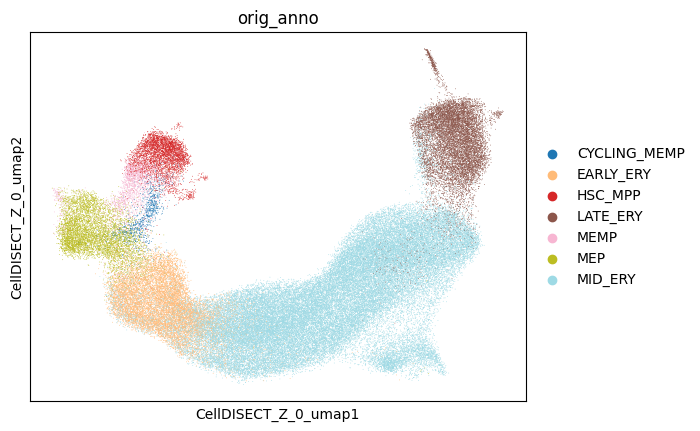

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.embedding(
    adata, 
    basis='CellDISECT_Z_0_umap',
    color='orig_anno',
    groups=celltypes, 
    palette='tab20',
    ax=ax,
    show=False,
)

# fig.savefig('ery_figs/z0_orig_anno.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/z0_orig_anno.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

<Axes: title={'center': 'orig_anno'}, xlabel='CellDISECT_Z_organ_umap1', ylabel='CellDISECT_Z_organ_umap2'>

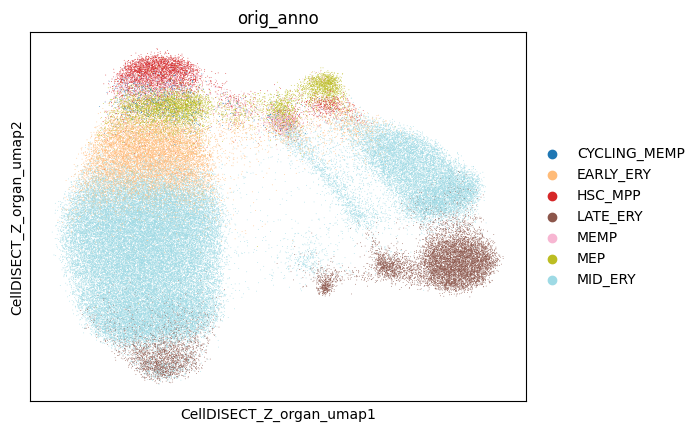

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.embedding(
    adata, 
    basis='CellDISECT_Z_organ_umap',
    color='orig_anno',
    groups=celltypes,
    ax=ax,
    show=False,
    )
# fig.savefig('ery_figs/zOrgan_orig_anno.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/zOrgan_orig_anno.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

### You can easily see the separation of different organs and cell types within one latent represantation (Z0+Organ) and you can analyse the different clusters

<Axes: title={'center': 'orig_anno'}, xlabel='CellDISECT_Z_0+organ_umap1', ylabel='CellDISECT_Z_0+organ_umap2'>

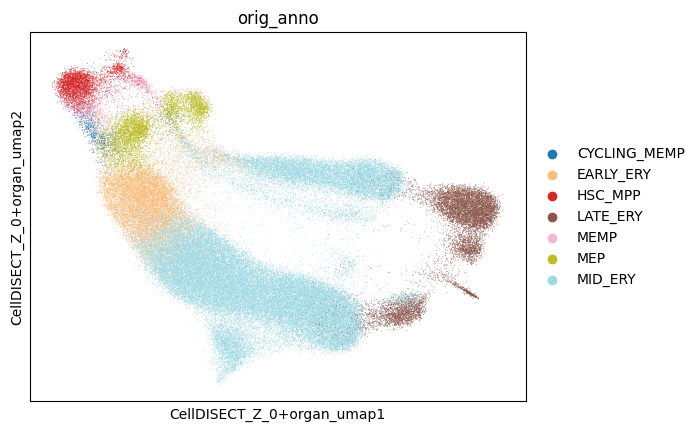

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.embedding(
    adata, basis='CellDISECT_Z_0+organ_umap', color='orig_anno', groups=celltypes,
    ax=ax,
    show=False,
    )
# fig.savefig('ery_figs/zOrgan+0_orig_anno.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/zOrgan+0_orig_anno.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

<Axes: title={'center': 'organ'}, xlabel='CellDISECT_Z_0+organ_umap1', ylabel='CellDISECT_Z_0+organ_umap2'>

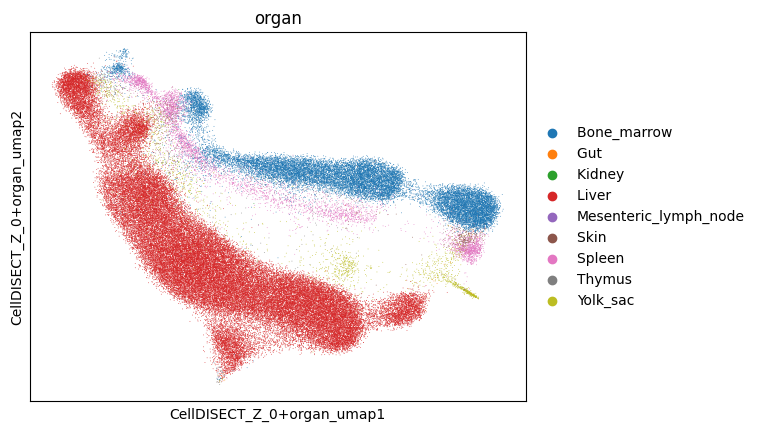

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.embedding(
    adata, basis='CellDISECT_Z_0+organ_umap', color='organ',
    ax=ax,
    show=False,
    )
# fig.savefig('ery_figs/zOrgan+0_organ.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/zOrgan+0_organ.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

## Now we want to take a closer look at Liver and Bone Marrow cells

In [19]:
adata = adata[adata.obs['organ'].isin(['Liver ', 'Bone_marrow '])].copy()
adata

AnnData object with n_obs × n_vars = 82585 × 8192
    obs: 'study', 'sample_ID', 'lane_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'sample_status', 'library_platform', 'strand_sequence', 'biological_unit', 'doi', 'institute', 'study_PI', 'subject_ID', 'ethnicity_1', 'ethnicity_2', 'disease_known', 'disease_condition', 'subject_type', 'sample_type', 'sample_cultured', 'anatomical_region', 'anatomical_region_level_2', 'protocol_tissue_dissociation', 'cell_enrichment', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sequencing_platform', 'Sample_orig_author', 'Anatomical_region_orig_author', 'Termination_method_orig_author', 'Method_orig_author', 'anno_lvl_2_final_clean_orig_author', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'author_batch', 'Chuan_meta_Original_Label', 'Chuan_meta_Harmonised_Label', 'Chuan_meta_Tissue', 'Chuan_meta_Technology', 'Chuan_meta_Donor', 'Chuan

### We recompute the neighbors for this subset

In [20]:
anno_col = 'orig_anno'
latent = 'CellDISECT_Z_0+organ'

sc.pp.neighbors(adata, n_neighbors=15, use_rep=latent)
sc.tl.umap(adata)

<Axes: title={'center': 'orig_anno'}, xlabel='UMAP1', ylabel='UMAP2'>

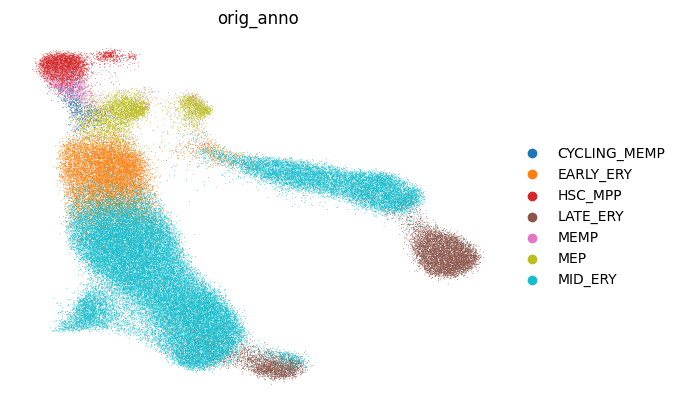

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color=anno_col,
    palette='tab10',
    frameon=False,
    ax=ax,
    show=False,
    )
# fig.savefig('ery_figs/subset_zrgan+0_organ.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/subset_zrgan+0_organ.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

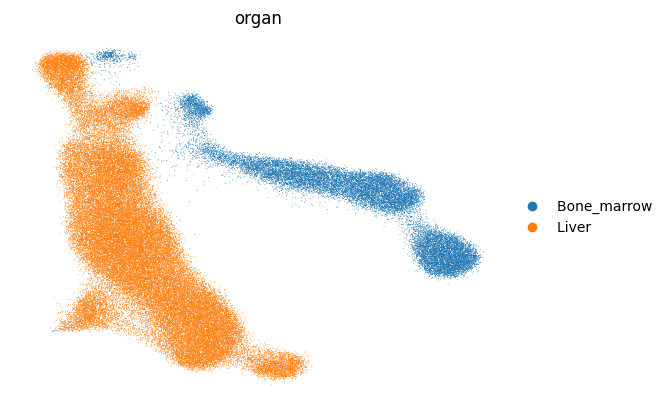

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color='organ',
    frameon=False,
    ax=ax,
    show=True,
    )
# fig.savefig('ery_figs/subset_zrgan+0_organ.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/subset_zrgan+0_organ.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)

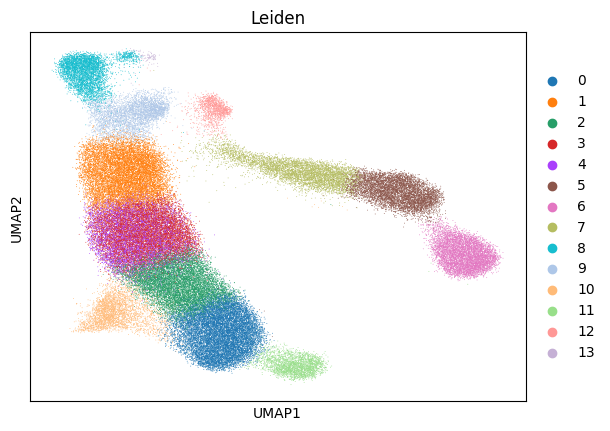

In [22]:
sc.tl.leiden(adata, key_added='Leiden', resolution = 2)
sc.pl.umap(adata, color='Leiden')

<Axes: title={'center': 'Leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

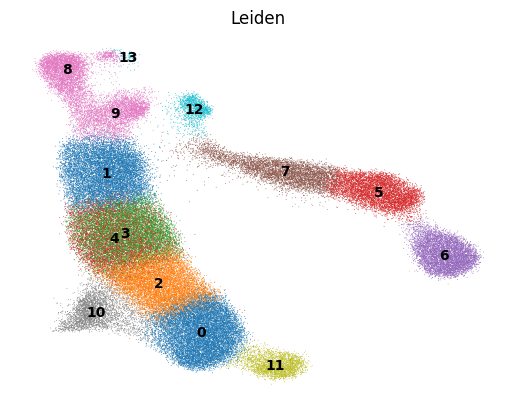

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(adata, color='Leiden', legend_loc = 'on data',
    palette='tab10',
    frameon=False,
    ax=ax,
    show=False,
    )
# fig.savefig('ery_figs/subset_zrgan+0_leiden.png', dpi=150, bbox_inches='tight')
# fig.savefig('ery_figs/subset_zrgan+0_leiden.svg', dpi=150, bbox_inches='tight')
# plt.show()
# plt.close(fig)